In [1]:
%pylab inline
figsize(12,8)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import clstm
from scipy.ndimage import filters

# Learning a Simple FIR Filter

Let's start generating training data. Training data consists of:

 - a distribution of input signals
 - a filtered version of the input signal giving the output signal

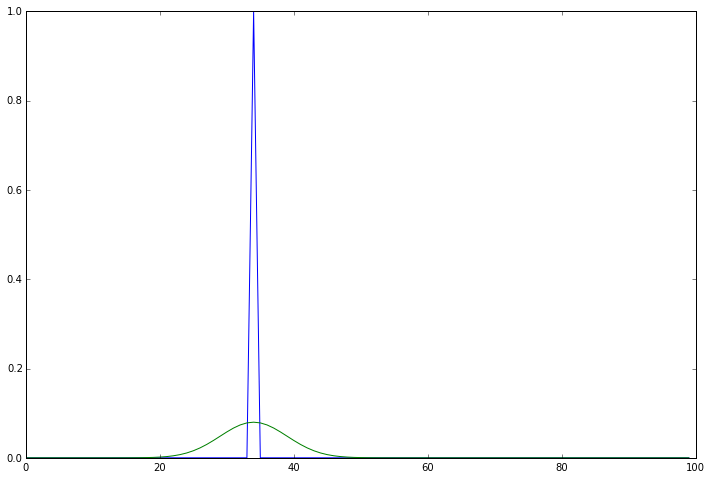

In [3]:
def gensig():
    xs = array(rand(100)<0.05,'f')
    return xs
def myfilter(xs):
    return filters.gaussian_filter(xs,5.0,mode='constant')
def gentest():
    xs = gensig()
    ys = myfilter(xs)
    return xs,ys
xs, ys = gentest()
plot(xs)
plot(ys)

Note that when specifying a linear filter, the distribution of the input signal doesn't matter. However, when learning a linear filter, the distribution does matter.

A sparse pulse train like the one above should make it particularly easy to learn a linear filter's impulse response.

We create a network, generate sequences, and train with those.

.bidilstm: 0.010000 0.900000 1 1
.bidilstm.parallel: 0.010000 0.900000 1 10
.bidilstm.parallel.lstm: 0.010000 0.900000 1 5
.bidilstm.parallel.reversed: 0.010000 0.900000 1 5
.bidilstm.parallel.reversed.lstm: 0.010000 0.900000 1 5
.bidilstm.full_linear: 0.010000 0.900000 10 1



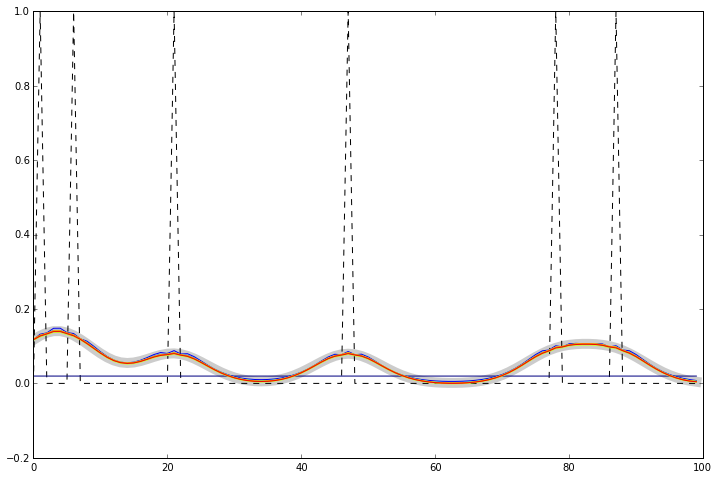

In [4]:
def train(ntrain=200000,nhidden=5,lrate=1e-2):
    global net,testin,testout
    net = clstm.make_net("BIDILSTM")
    net.set("ninput",1)
    net.set("nhidden",nhidden)
    net.set("noutput",1)
    net.set("output_type","LinearLayer")
    net.initialize()
    net.setLearningRate(lrate,0.9)
    print clstm.network_info(net)

    testin,testout = gentest()
    plot(testin, '--', c='black')
    plot(testout, c="black", linewidth=10, alpha=0.2)
    ntrain = ntrain
    for i in range(ntrain):
        xs,ys = gentest()
        net.inputs.aset(xs.reshape(-1,1,1))
        net.forward()
        net.d_outputs.aset(ys.reshape(-1,1,1)-net.outputs.array())
        net.backward()
        net.update()
        if i%(ntrain//10)==0:
            net.inputs.aset(testin.reshape(-1,1,1))
            net.forward()
            plot(net.outputs.array()[:,0,0],c=cm.jet(i*1.0/ntrain))
train()

That looks pretty good. Let's look at the impulse response.

In [5]:
def predict(net,xs):
    net.inputs.aset(xs.reshape(-1,1,1))
    net.forward()
    return net.outputs.array()[:,0,0]

In [6]:
impulse = zeros(100,'f')
impulse[50] = 1.0

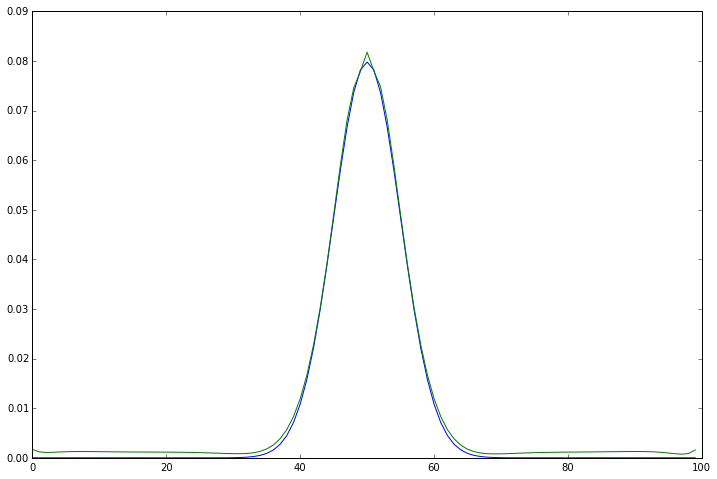

In [7]:
plot(filters.gaussian_filter(impulse,5.0))
plot(predict(net,impulse))

As we can see, the impulse response is very well reproduced. In essence, the LSTM acts like a pair of IIR filters, combined into a filter that closely approximates the original FIR filter. Note that the footprint of the filter is about 30 steps, but it is well approximated with just 5 taps.

# Large Filters

Let's try to push this to even larger filters and pick a much larger Gaussian.

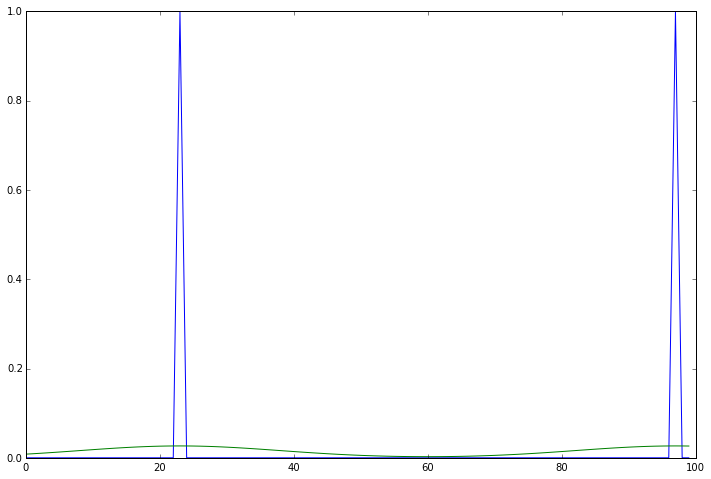

In [8]:
def myfilter(xs):
    return filters.gaussian_filter(xs,15.0,mode='constant')
xs,ys = gentest()
plot(xs)
plot(ys)

.bidilstm: 0.010000 0.900000 1 1
.bidilstm.parallel: 0.010000 0.900000 1 10
.bidilstm.parallel.lstm: 0.010000 0.900000 1 5
.bidilstm.parallel.reversed: 0.010000 0.900000 1 5
.bidilstm.parallel.reversed.lstm: 0.010000 0.900000 1 5
.bidilstm.full_linear: 0.010000 0.900000 10 1



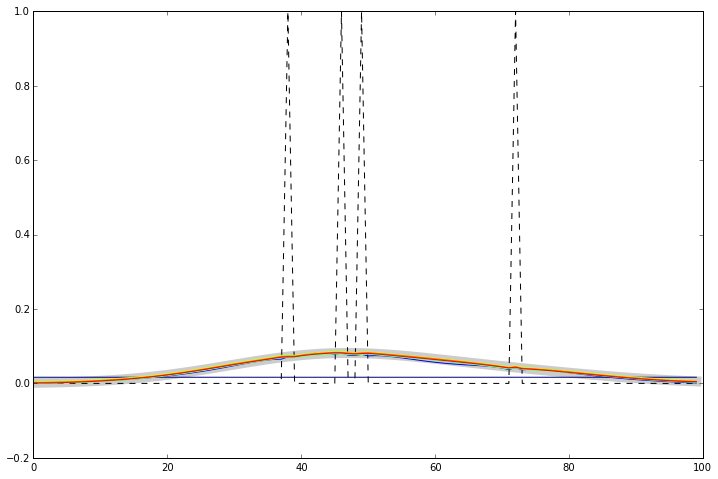

In [9]:
train(ntrain=250000)

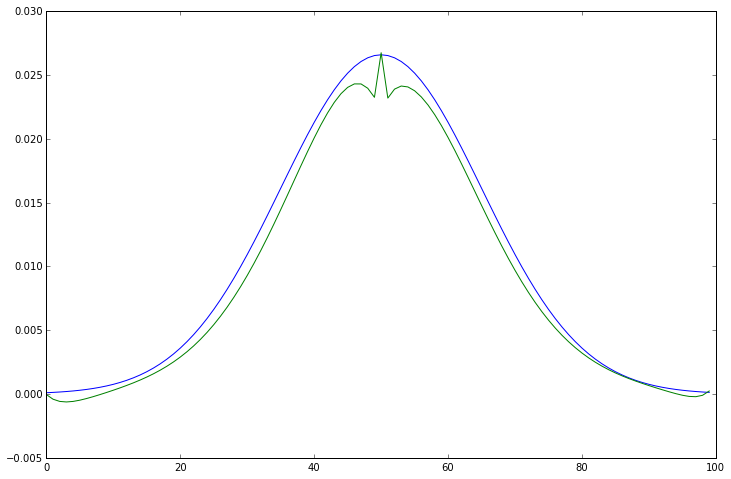

In [10]:
plot(myfilter(impulse))
plot(predict(net,impulse))

This is still a pretty good approximation, given a 5 tap filter. The deviations would likely go away with longer training sequences (boundary effects are becoming significant) and more training.

# Different Training Data

In the previous examples, the training data was a sparse pulse train, which seems almost ideal for recovering the filter. What happens if we use different training data? A Cauchy process generates a 1D "Mondrian-like" signal (mostly flat areas separated by jumps), containing nothing like an impulse.

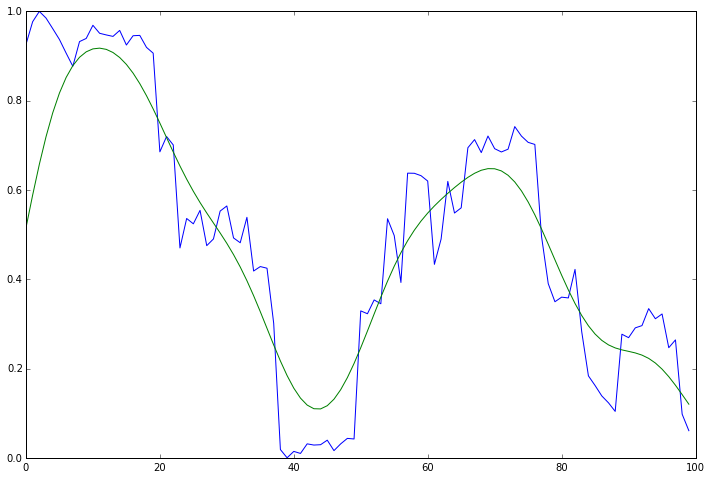

In [11]:
def myfilter(xs):
    return filters.gaussian_filter(xs,5.0,mode='constant')
def gensig(N=100):
    xs = numpy.random.standard_cauchy(N)
    xs = add.accumulate(xs)
    xs -= amin(xs); xs /= amax(xs)
    return array(xs,'f')
xs,ys = gentest()
plot(xs)
plot(ys)

.bidilstm: 0.010000 0.900000 1 1
.bidilstm.parallel: 0.010000 0.900000 1 10
.bidilstm.parallel.lstm: 0.010000 0.900000 1 5
.bidilstm.parallel.reversed: 0.010000 0.900000 1 5
.bidilstm.parallel.reversed.lstm: 0.010000 0.900000 1 5
.bidilstm.full_linear: 0.010000 0.900000 10 1



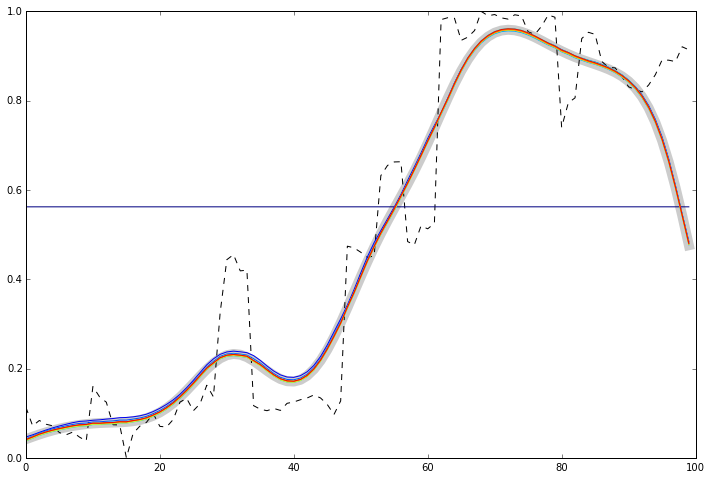

In [12]:
train()

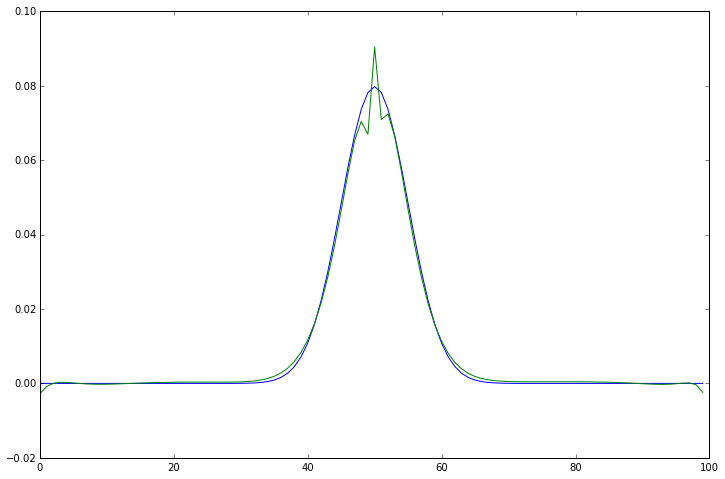

In [13]:
plot(myfilter(impulse))
plot(predict(net,impulse))

The impulse response is still a pretty good approximation. More training data would likely improve it further.

# Other FIR Filters (Derivatives of Gaussians)

Let's try some other FIR filters, namely derivatives of Gaussians of first and second order.

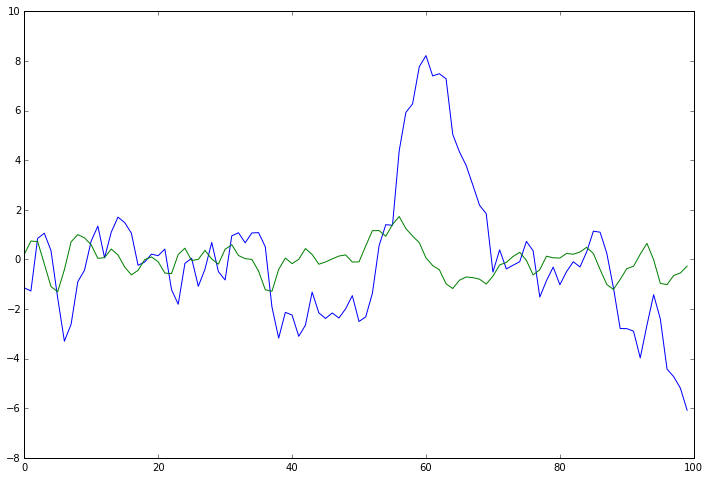

In [14]:
def gensig():
    xs = array(add.accumulate(randn(100)),'f')
    xs -= filters.gaussian_filter(xs,20.0)
    return xs
def myfilter(xs):
    return filters.gaussian_filter(xs,1.0,order=1)
xs = gensig()
plot(xs)
plot(myfilter(xs))

.bidilstm: 0.010000 0.900000 1 1
.bidilstm.parallel: 0.010000 0.900000 1 10
.bidilstm.parallel.lstm: 0.010000 0.900000 1 5
.bidilstm.parallel.reversed: 0.010000 0.900000 1 5
.bidilstm.parallel.reversed.lstm: 0.010000 0.900000 1 5
.bidilstm.full_linear: 0.010000 0.900000 10 1



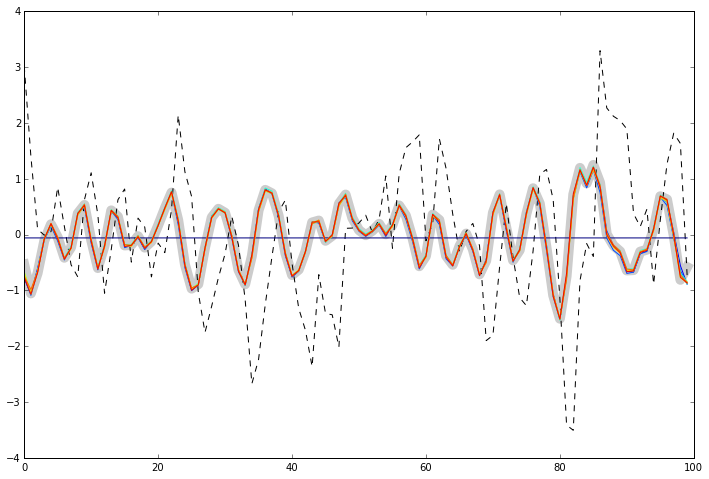

In [15]:
train()

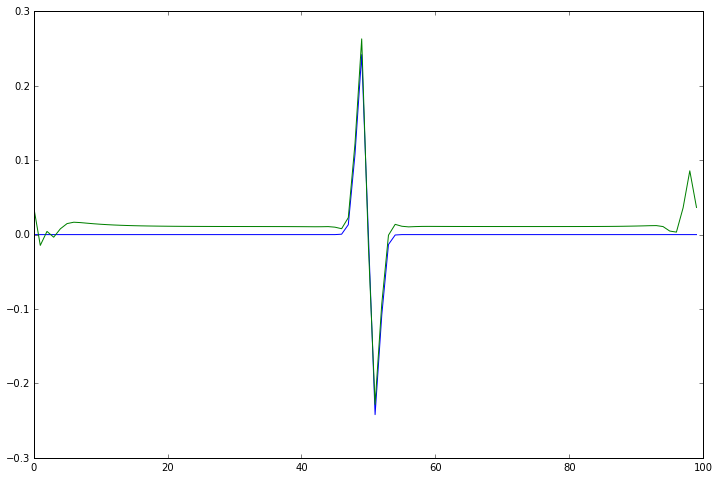

In [16]:
plot(myfilter(impulse))
plot(predict(net,impulse))

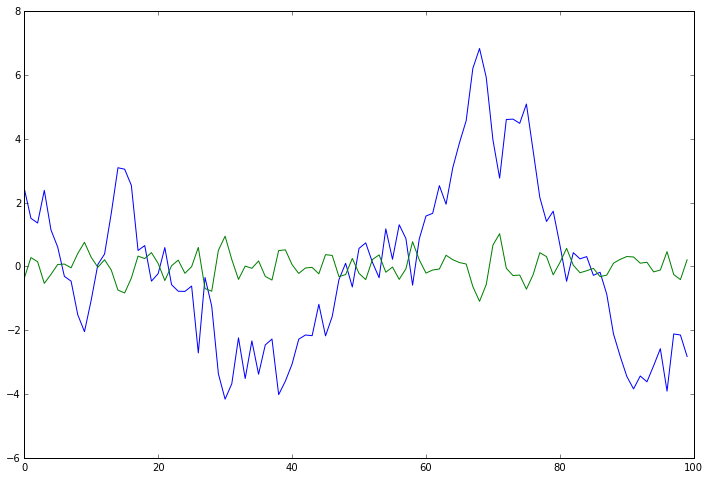

In [17]:
def myfilter(xs):
    return filters.gaussian_filter(xs,1.0,order=2)
xs = gensig()
plot(xs)
plot(myfilter(xs))

.bidilstm: 0.010000 0.900000 1 1
.bidilstm.parallel: 0.010000 0.900000 1 20
.bidilstm.parallel.lstm: 0.010000 0.900000 1 10
.bidilstm.parallel.reversed: 0.010000 0.900000 1 10
.bidilstm.parallel.reversed.lstm: 0.010000 0.900000 1 10
.bidilstm.full_linear: 0.010000 0.900000 20 1



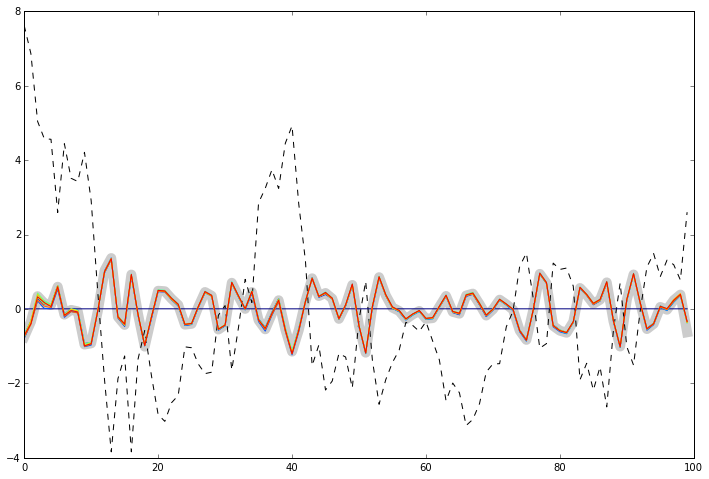

In [18]:
train(nhidden=10)

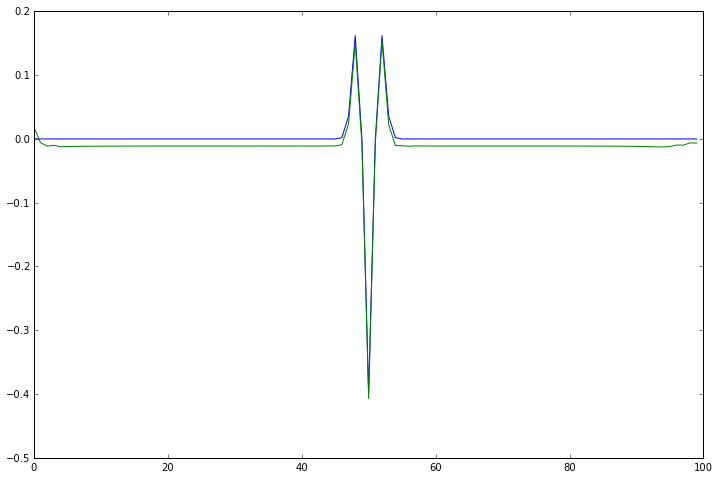

In [19]:
plot(myfilter(impulse))
plot(predict(net,impulse))

# Maximum Filter

Let's try a non-linear filter, namely a maximum filter.

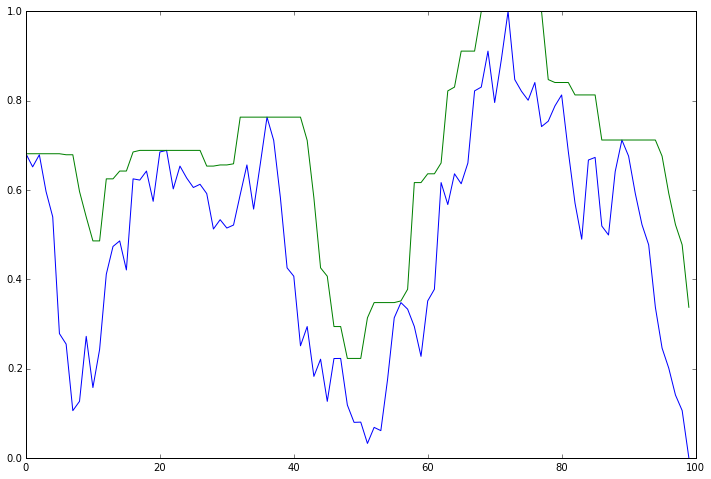

In [20]:
def gensig():
    xs = array(add.accumulate(randn(100)),'f')
    xs -= filters.gaussian_filter(xs,20.0)
    xs -= amin(xs)
    xs /= amax(xs)
    return xs
def myfilter(xs):
    return filters.maximum_filter(xs,10,mode='constant')
xs,ys = gentest()
plot(xs)
plot(ys)

.bidilstm: 0.010000 0.900000 1 1
.bidilstm.parallel: 0.010000 0.900000 1 100
.bidilstm.parallel.lstm: 0.010000 0.900000 1 50
.bidilstm.parallel.reversed: 0.010000 0.900000 1 50
.bidilstm.parallel.reversed.lstm: 0.010000 0.900000 1 50
.bidilstm.full_linear: 0.010000 0.900000 100 1



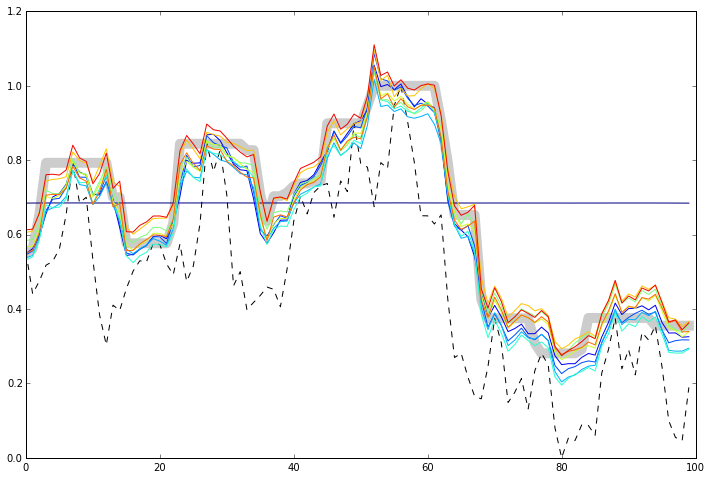

In [21]:
train(ntrain=500000,nhidden=50)

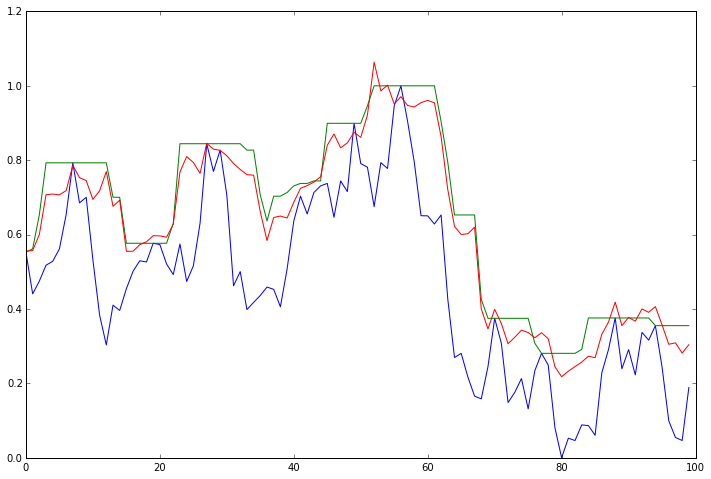

In [22]:
plot(testin)
plot(testout)
plot(predict(net,testin))

# Median Filter

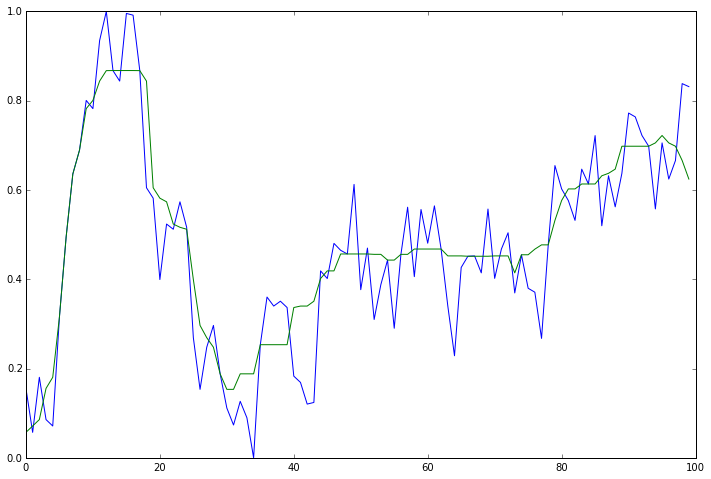

In [23]:
def myfilter(xs):
    return filters.median_filter(xs,10,mode='constant')
xs,ys = gentest()
plot(xs)
plot(ys)

.bidilstm: 0.010000 0.900000 1 1
.bidilstm.parallel: 0.010000 0.900000 1 100
.bidilstm.parallel.lstm: 0.010000 0.900000 1 50
.bidilstm.parallel.reversed: 0.010000 0.900000 1 50
.bidilstm.parallel.reversed.lstm: 0.010000 0.900000 1 50
.bidilstm.full_linear: 0.010000 0.900000 100 1



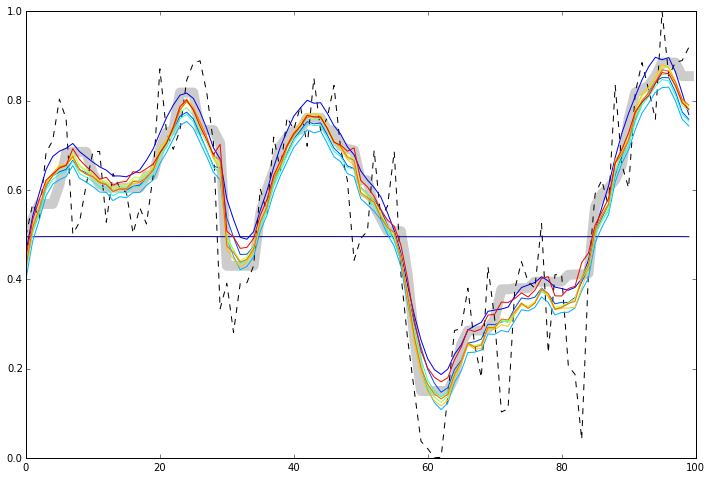

In [24]:
train(ntrain=500000,nhidden=50)

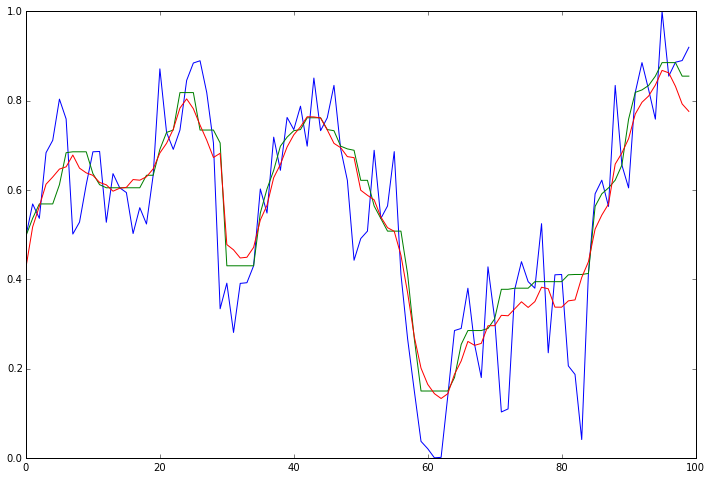

In [25]:
plot(testin)
plot(testout)
plot(predict(net,testin))

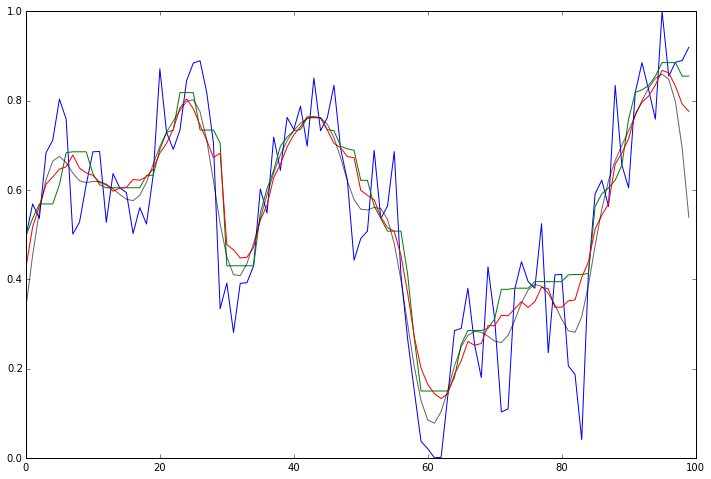

In [26]:
plot(testin)
plot(testout)
plot(predict(net,testin))
for s in [2.0]:
    plot(filters.gaussian_filter(testin,s,mode='constant'),alpha=0.6,color='black')

# Median Filter with Gaussian Process and Shot Noise

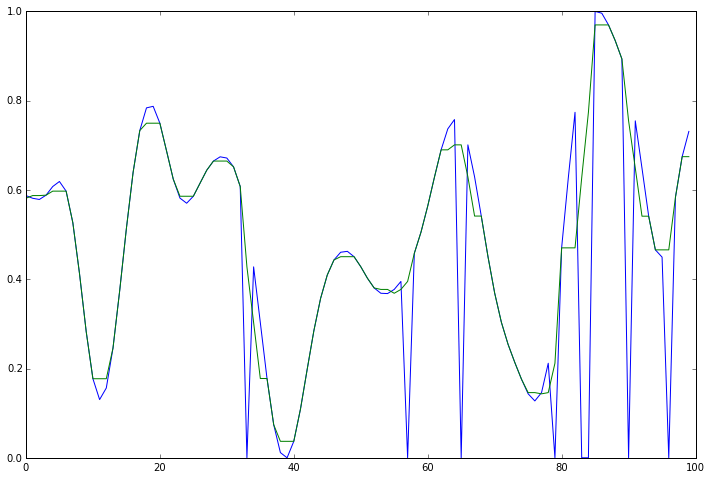

In [27]:
def gensig():
    xs = array(rand(100),'f')
    xs = filters.gaussian_filter(xs,3.0)
    xs -= amin(xs); xs /= amax(xs)
    return where(rand(len(xs))<0.1,0,xs)
def myfilter(xs):
    return filters.median_filter(xs,5.0)
xs,ys = gentest()
plot(xs)
plot(ys)

.bidilstm: 0.010000 0.900000 1 1
.bidilstm.parallel: 0.010000 0.900000 1 100
.bidilstm.parallel.lstm: 0.010000 0.900000 1 50
.bidilstm.parallel.reversed: 0.010000 0.900000 1 50
.bidilstm.parallel.reversed.lstm: 0.010000 0.900000 1 50
.bidilstm.full_linear: 0.010000 0.900000 100 1



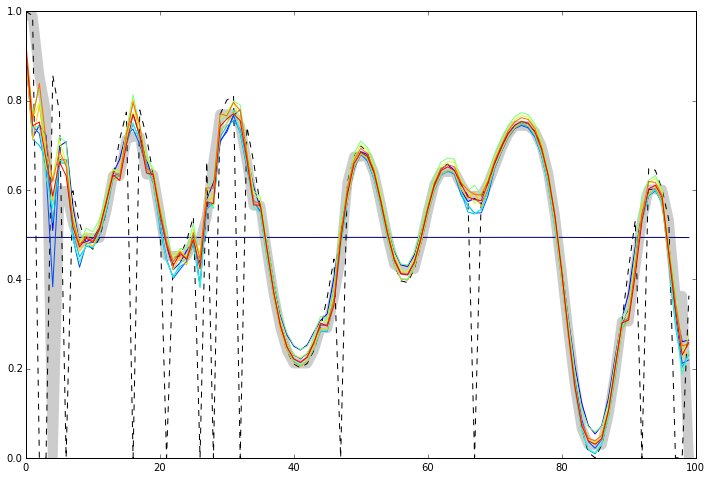

In [28]:
train(ntrain=500000,nhidden=50)

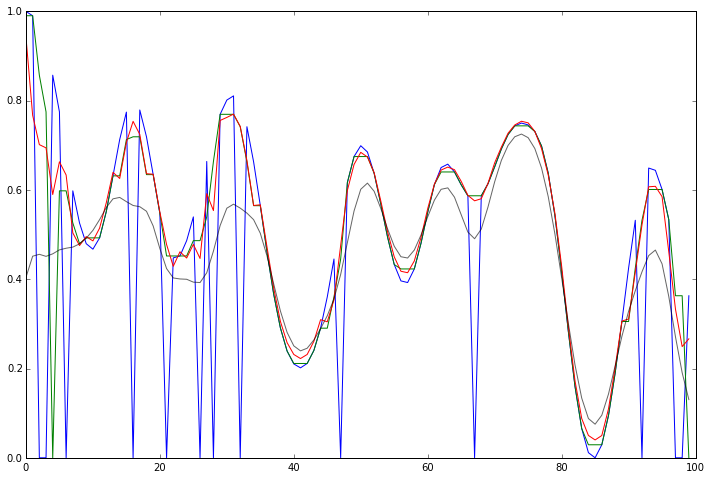

In [29]:
plot(testin)
plot(testout)
plot(predict(net,testin))
for s in [2.0]:
    plot(filters.gaussian_filter(testin,s,mode='constant'),alpha=0.6,color='black')

# Median Filter with Cauchy Process and Shot Noise

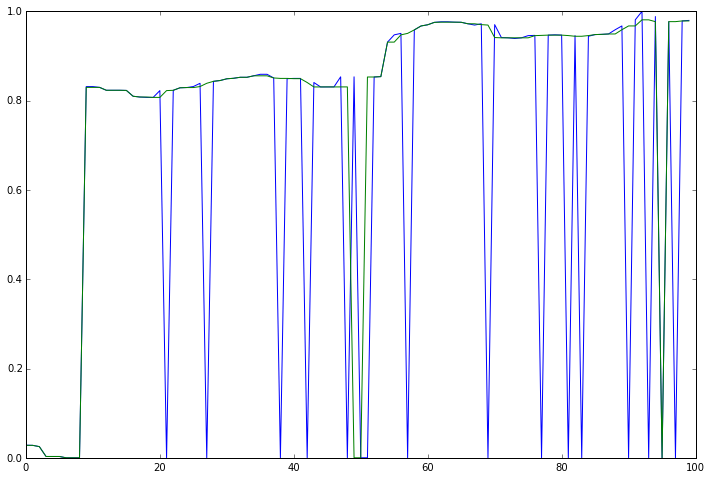

In [30]:
def gensig(N=100):
    xs = array(numpy.random.standard_cauchy(N),'f')
    xs = add.accumulate(xs)
    xs = filters.median_filter(xs,3.0)
    xs -= amin(xs); xs /= amax(xs)
    return where(rand(len(xs))<0.1,0,xs)
xs = gensig()
plot(xs)
plot(myfilter(xs))

.bidilstm: 0.010000 0.900000 1 1
.bidilstm.parallel: 0.010000 0.900000 1 100
.bidilstm.parallel.lstm: 0.010000 0.900000 1 50
.bidilstm.parallel.reversed: 0.010000 0.900000 1 50
.bidilstm.parallel.reversed.lstm: 0.010000 0.900000 1 50
.bidilstm.full_linear: 0.010000 0.900000 100 1



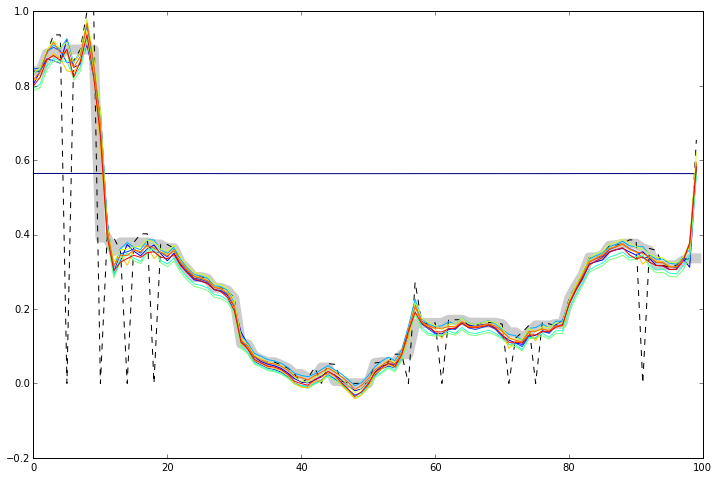

In [31]:
train(ntrain=500000,nhidden=50)

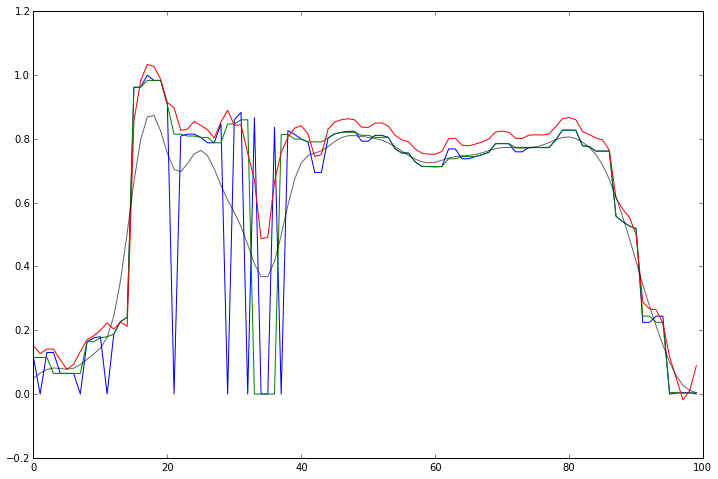

In [32]:
testin,testout = gentest()
plot(testin)
plot(testout)
plot(predict(net,testin))
for s in [2.0]:
    plot(filters.gaussian_filter(testin,s,mode='constant'),alpha=0.6,color='black')